In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '20.05_27.05_rodrigezzzzzzzzzz'

In [143]:
# todo plot iters
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs):
    job_log = current_milestone / '{}.out'.format(job_id)

    try:
        exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(job_log)
        batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
        n_epochs = int(n_max_epochs)
        xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch

        if title:
            title = 'job #{}: "{}"'.format(job_id, title)
        else:
            title = ''

        plot_losses(
            ax, epochs[:n_epochs], xrange,
            title=title, xlabel='# batch iterations'
        )

        plot_metrics(
            ax.twinx(), epochs[:n_epochs], xrange,
            train_metric_ylim=metrics_ylim,
            eval_metric_ylim=metrics_ylim,
            metric_ylabel='average MPJPE relative to pelvis (mm)',
            with_SOTA=True
        )

        plot_lr(ax, lr_reductions, batch_amount_per_epoch)

        make_axis_great_again(ax, xlim=xrange, ylim=[0, 1e2], hide_y=True)
    except StopIteration:
        print('does {} even contain 1 complete epoch ??'.format(job_log))

    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2], n_max_epochs=1e3):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row

    if len(jobs) > 1:
        for ax, job_id, title in zip(axis.ravel(), jobs, titles):
            plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs)
    else:
        plot_job(axis, jobs[0], titles[0], training_batch_size, metrics_ylim, n_max_epochs)

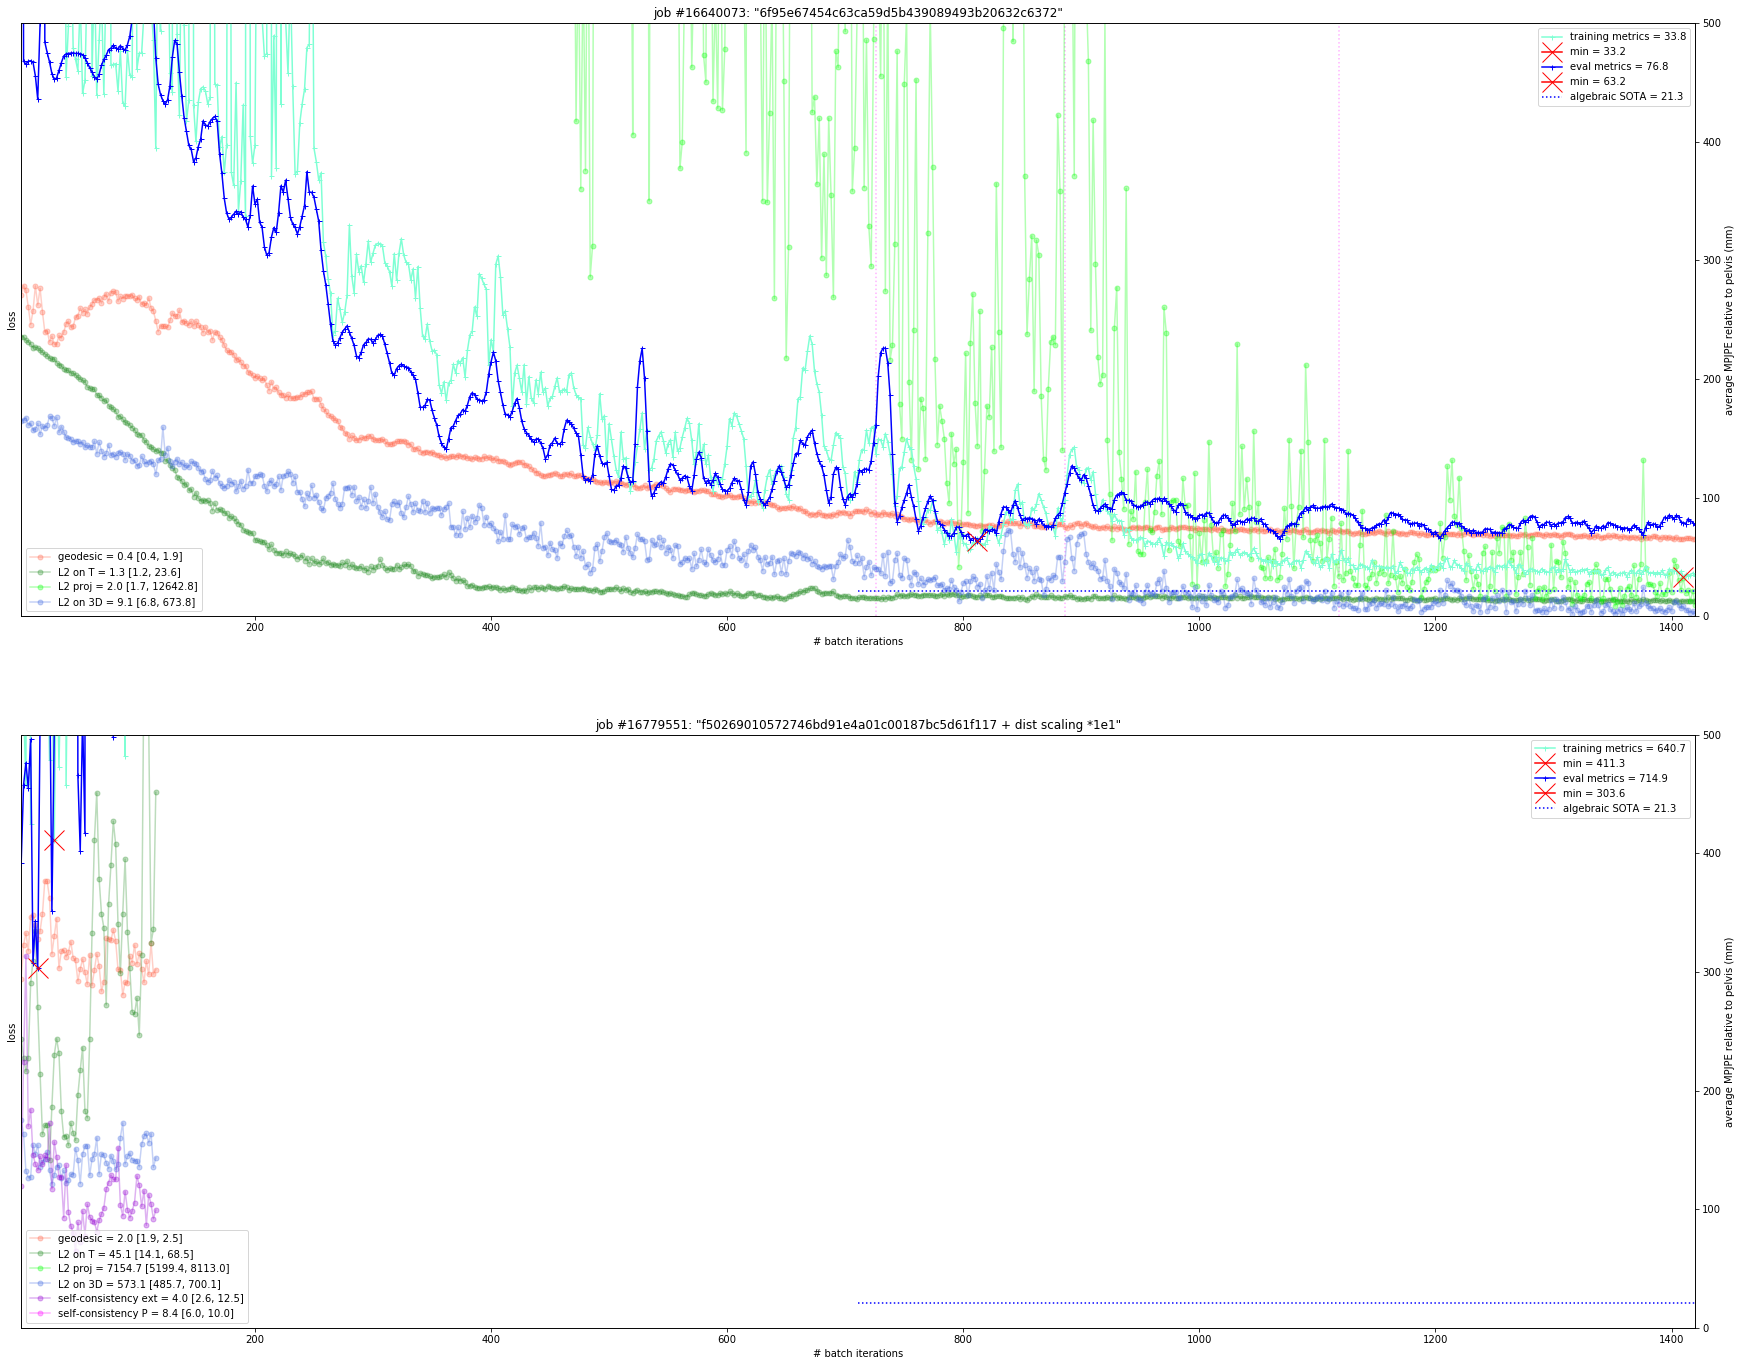

In [145]:
jobs = list(zip(*[
    # SOTA superv R|t
    ('16640073', '6f95e67454c63ca59d5b439089493b20632c6372'),
    # ('16779861', 'checkout 6f95e67454c63ca59d5b439089493b20632c6372'),
    #('16647158', '=16640073, 10% dataset'),
    
    # SOTA superv R|t (pelvis sitting on origin => predict just d)
    # ('16700068', '=1ac51aa18715346b37153df517d7e9fb94c23ec6 but with Rod'),  # 16700001 with 6D
    # ('16772316', '12dd4864cbc7e8e66308cb10b056f84e22e78f97 + normalize by mean Fro'),
    ('16779551', 'f50269010572746bd91e4a01c00187bc5d61f117 + dist scaling *1e1'),
     
    # SOTA unsuperv R|t (pelvis sitting on origin)
    #('16712639', '=6db8028fad6b731816d08678900ca14b94f57dab but no KP centering'),  # 16711084
    
    # SOTA unsuperv 3D, R|t (pelvis sitting on origin)
    #('16729378', '39d6babb5babf6b26e4dff29a1008c703d6ab918'),  # 16721459
    #('16731852', '217c24c7eb0790bb825015a696623de0d4177eea but wdecy=2, gclip=0.25'),  # 16731537
]))

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 5e2], n_max_epochs=7.1e2)

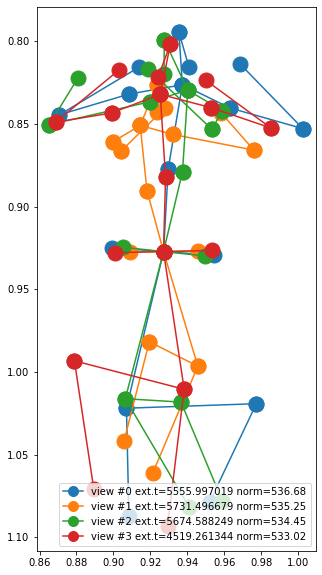

In [129]:
import matplotlib.colors as mcolors

from viz import draw_kp_in_2d
from mvn.pipeline.cam2cam import _normalize_fro_kps

keypoints_2d = torch.load('/home/stefano/_tmp/logs/human36m_alg_AlgebraicTriangulationNet@26.05.2021-12:54:19/epoch-0-iter-0/kps.trc')

fig, axis = get_figa(1, 1, heigth=10, width=5)
colors = list(mcolors.TABLEAU_COLORS.values())
ds = [5555.997019031487, 5731.496679157848, 5674.588249077968, 4519.2613436342635]
for view_i, color, d in zip(range(keypoints_2d.shape[1]), colors, ds):
    kps = keypoints_2d[0, view_i]
    # kps = _normalize_fro_kps(keypoints_2d, False)[0, view_i]
    norm = torch.norm(kps, p='fro') * 1e2
    
    label = 'view #{:0d} ext.t={:1f} norm={:.2f}'.format(view_i, d, norm)
    draw_kp_in_2d(axis, kps.cpu().numpy(), label, color)

axis.set_ylim(axis.get_ylim()[::-1])
axis.legend(loc='lower right')